# PyTorch Layer 이해하기

# 예제 불러오기

In [1]:
import torch
from torchvision import datasets, transforms

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('dataset', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=1)

100.1%

Extracting dataset\MNIST\raw\train-images-idx3-ubyte.gz to dataset\MNIST\raw


113.5%

Extracting dataset\MNIST\raw\train-labels-idx1-ubyte.gz to dataset\MNIST\raw


100.4%

Extracting dataset\MNIST\raw\t10k-images-idx3-ubyte.gz to dataset\MNIST\raw


180.4%

Extracting dataset\MNIST\raw\t10k-labels-idx1-ubyte.gz to dataset\MNIST\raw
Processing...
Done!


In [4]:
image, label = next(iter(train_loader))

In [5]:
# batch_size, channel, h, w
image.shape, label.shape

(torch.Size([1, 1, 28, 28]), torch.Size([1]))

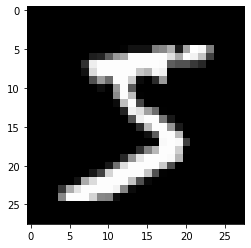

In [7]:
plt.imshow(image[0, 0, :, :], 'gray')
plt.show()

# 각 Layer별 설명

- Network 쌓기 위한 준비

In [8]:
import torch

# layer nn과 f
import torch.nn as nn  # weight가 있는 것
import torch.nn.functional as F # function, weight가 없는 것

### Convolution

- in_channels: 받게 될 channel의 갯수
- out_channels: 보내고 싶은 channel의 갯수  
- kernel_size: 만들고 싶은 kernel(weights)의 사이즈

In [15]:
nn.Conv2d(in_channels=1, # 사진이 1개니까 input이 1
          out_channels=20, # tensorflow에서는 이것만 있었음
          kernel_size=5, # (5,5)
          stride=1)

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

In [10]:
# 이렇게 써도 순서만 맞으면 작동됨
layer = nn.Conv2d(1, 20, 5, 1).to(torch.device('cpu'))
layer #(in, out)

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

- weight 시각화를 위해 slice하고 numpy화

In [11]:
weight = layer.weight
weight.shape

torch.Size([20, 1, 5, 5])

- 여기서 weight는 학습 가능한 상태이기 때문에(변동이 쉽도록 만들어진 상태) 바로 numpy로 뽑아낼 수 없음
- detach() method는 그래프에서 잠깐 빼서 gradient에 영향을 받지 않게 함

In [12]:
weight.numpy()

RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

In [13]:
weight = weight.detach().numpy()

In [14]:
weight.shape

(20, 1, 5, 5)

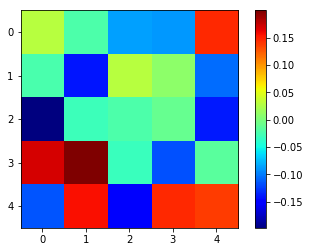

In [25]:
plt.imshow(weight[0, 0, :, :], 'jet') # 1번째 것
plt.colorbar()
plt.show()

- output 시각화 준비를 위해 numpy화

In [26]:
output_data = layer(image)

In [27]:
output_data = output_data.data

In [29]:
output = output_data.cpu().numpy() # cpu로 컴파일 후 numpy로 변환

In [30]:
output.shape # convolution을 거친 이미지

(1, 20, 24, 24)

- Input으로 들어간 이미지 numpy화 

In [22]:
image_arr = image.numpy() # 원래 이미지
image_arr.shape

(1, 1, 28, 28)

In [23]:
np.squeeze(image_arr).shape

(28, 28)

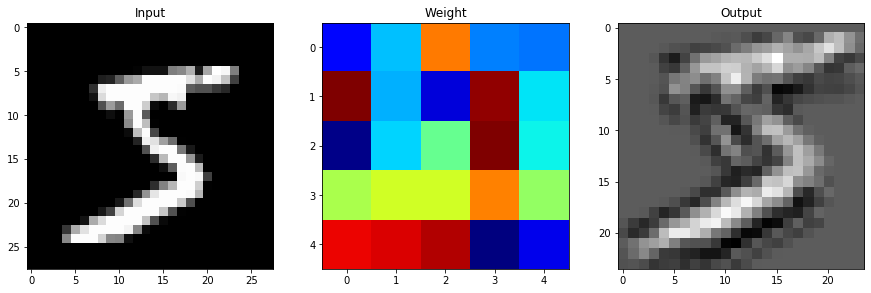

In [31]:
plt.figure(figsize=(15, 30))
plt.subplot(131)
plt.title('Input')
# np.squeeze(image_arr) : image_arr에서 batch_size와 channel 지우기
plt.imshow(np.squeeze(image_arr), 'gray')  # 원래 이미지
plt.subplot(132)
plt.title('Weight')
plt.imshow(weight[0, 0, :, :], 'jet') # weight : filter
plt.subplot(133)
plt.title('Output')
plt.imshow(output[0, 0, :, :], 'gray') # image_arr과 weight를 합성곱한 결과물 
plt.show()

### Pooling

input을 먼저 앞에 넣고, 뒤에 kernel 사이즈와 stride를 순서대로 넣음

In [32]:
image.shape

torch.Size([1, 1, 28, 28])

In [33]:
# 크기가 28 > 14, 절반으로 줄어듬
pool = F.max_pool2d(image, 2, 2)
pool.shape

torch.Size([1, 1, 14, 14])

- MaxPool Layer는 weight가 없기 때문에 바로 numpy()가 가능

In [34]:
# detach 필요 없음
pool_arr = pool.numpy()
pool_arr.shape

(1, 1, 14, 14)

In [35]:
image_arr.shape # 원래 이미지

(1, 1, 28, 28)

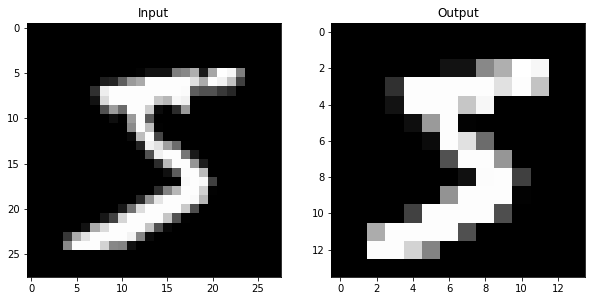

In [37]:
# squeeze: 1,1 없애기

plt.figure(figsize=(10, 15))
plt.subplot(121)
plt.title("Input")
plt.imshow(np.squeeze(image_arr), 'gray') # 원래 이미지
plt.subplot(122)
plt.title('Output')
plt.imshow(np.squeeze(pool_arr), 'gray') # pooling한 결과물, 즉 단순화한 결과물(픽셀들이 커짐)
plt.show()

### Linear

nn.Linear는 2d가 아닌 1d만 들어가기 때문에 .view() 1D로 펼쳐줘야함

In [38]:
image.shape

torch.Size([1, 1, 28, 28])

In [39]:
flatten = image.view(1, 28 * 28) # 한줄로 펼치기
flatten.shape

torch.Size([1, 784])

In [40]:
# 784개를 받아서 10개로 내보낸다
# Dense와 같은 것(input_dims = 784, 1번째 매개변수 = 10)
lin = nn.Linear(784, 10)(flatten) 
lin.shape

torch.Size([1, 10])

In [41]:
lin

tensor([[-0.2507,  0.0252, -0.0056, -0.4682, -0.1734,  0.2265, -0.0829,  0.0398,
          0.0562,  0.0771]], grad_fn=<AddmmBackward>)

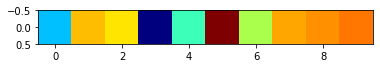

In [43]:
plt.imshow(lin.detach().numpy(), 'jet')
plt.show()

### Softmax

결과를 numpy로 꺼내기 위해선 weight가 담긴 Linear에 weight를 꺼줘야함

In [45]:
# 학습모드에서는 결과를 볼 수 없기에 no_grad 가 필요

# default로 autograd를 작동시키기에 no_grad가 없으면 back propogation을 자동으로 실행해서 w를 학습시킨다.
# weight 계산을 하게 되면 이는 변동이 가능한 값dlrh, 변동이 일어나기에 그 결과를 볼 수 없다.
# 그래서 결과를 보기 위해서는 no_grad를 넣어서 자동 w update를 막는 것이다.

with torch.no_grad():
    flatten = image.view(1, 28 * 28)
    lin = nn.Linear(784, 10)(flatten) # 여기까지 위헤 있던 내용
    softmax = F.softmax(lin, dim=1) # Dense로 weight로 계산한 다음 softmax로 filtering

In [46]:
softmax # 각 class(10개) 중 어디에 속할지 확률

tensor([[0.1510, 0.0901, 0.0995, 0.0995, 0.0798, 0.0793, 0.0989, 0.0725, 0.1224,
         0.1071]])

In [47]:
np.sum(softmax.numpy())

1.0000001

# Layer 쌓기

예제 출처: https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#id23

nn 과 nn.functional의 차이점
- nn은 학습 파라미터가 담긴 것 
- nn.functional은 학습 파라미터가 없는 것이라 생각하면 간단

In [61]:
# 일반적으로 layer를 class로 만들어서 쌓는다.
class Net(nn.Module): 
    def __init__(self):
        # 여기에는 학습이 가능한 것 = weight가 있는 것 을 쓴다.
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1) # in, out, kernal_size, stride
        self.conv2 = nn.Conv2d(20, 50, 5, 1) 
        self.fc1 = nn.Linear(4*4*50, 500) # fully connected
        self.fc2 = nn.Linear(500, 10) # 500: 위의 결과를 받음
        
    def forward(self, x):
        # 위의 학습 가능한 요소들로 학습 시작
        
        # Feature Extraction
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
        print(x)
        print(x.shape)
        # Fully Connected (Classficiation)
        x = x.view(-1, 4*4*50) # 4*4*50 부분에 어떤 걸 넣어야하는지 모르겠으면 print로 찍은 것의 shape을 보면 됨
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

- Image를 Model에 넣어서 결과 확인

In [62]:
model = Net()

In [63]:
result = model.forward(image) # print 내용

tensor([[[[3.1605e-01, 3.4131e-01, 4.4187e-01, 4.3743e-01],
          [3.3141e-01, 5.1719e-01, 4.6009e-01, 3.5148e-01],
          [1.2570e-01, 2.9815e-01, 3.5870e-01, 3.2957e-01],
          [1.5107e-01, 3.2693e-01, 5.4810e-01, 3.4752e-01]],

         [[2.4694e-01, 1.9178e-01, 1.6219e-01, 7.9269e-02],
          [2.6936e-01, 2.1903e-01, 5.1180e-02, 0.0000e+00],
          [1.7747e-01, 2.1208e-01, 2.4895e-01, 0.0000e+00],
          [1.5213e-01, 1.4525e-01, 1.5625e-01, 0.0000e+00]],

         [[0.0000e+00, 0.0000e+00, 1.2151e-01, 2.7154e-01],
          [9.7378e-02, 3.6982e-02, 1.0825e-01, 1.4586e-01],
          [4.9580e-02, 0.0000e+00, 0.0000e+00, 2.1639e-01],
          [0.0000e+00, 0.0000e+00, 1.2114e-01, 2.9752e-01]],

         [[1.5932e-02, 3.8783e-01, 3.5485e-01, 2.2845e-01],
          [1.7671e-01, 3.3649e-01, 2.0813e-01, 9.2106e-02],
          [1.7581e-01, 1.2124e-01, 8.6105e-02, 2.1308e-01],
          [6.2786e-02, 1.6171e-01, 2.6499e-01, 2.2795e-01]],

         [[0.0000e+00, 3.0847e-0

In [64]:
result.shape

torch.Size([1, 10])

In [65]:
result

tensor([[-2.3228, -2.2600, -2.2700, -2.3033, -2.3425, -2.2941, -2.3248, -2.2423,
         -2.3319, -2.3399]], grad_fn=<LogSoftmaxBackward>)

In [66]:
model.conv1 # 위에서 우리가 만든 conv

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))